In [1]:
import argparse
import math
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from src.utils import adversarial_accuracy, fgsm_, compare_models_on_measure
from src.gradient_masking_tests import gradient_norm, fgsm_pgd_cos_dif, multi_scale_fgsm, gradient_information, linearization_error, pgd_colinearity
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, CUREResNet18

In [2]:
# setup
device = torch.device("cpu")
batch_size = 128
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load CIFAR-10 models

In [3]:
# # Regular CIFAR-10  ResNet Model
model = CIFAR_Res_Net().eval().to(device)
model.load_state_dict(torch.load("../models/normal_20e.model", map_location=device))
# CIFAR-10  ResNet Model trained with pgd 03
pgd_model = CIFAR_Res_Net().to(device).eval()
pgd_model.load_state_dict(torch.load("../models/pgd_e8_20e.model", map_location=device))
#CIFAR-10  ResNet Model trained with pgd 06
pgd_model_6 = CIFAR_Res_Net().to(device).eval()
pgd_model_6.load_state_dict(torch.load("../models/pgd_e16_20e.model", map_location=device))
#CIFAR-10  ResNet Model trained with large FGSM steps
fgsm_model = CIFAR_Res_Net().to(device).eval()
fgsm_model.load_state_dict(torch.load("../models/fgsm_e16_20e.model", map_location=device))
# # # # CIFAR-10  ResNet Model trained with small FGSM steps (grad mask)
fgsm_model_small = CIFAR_Res_Net().to(device).eval()
fgsm_model_small.load_state_dict(torch.load("../models/fgsm_e8_20e.model", map_location=device))
# # # # CIFAR-10  ResNet Model trained with small FGSM steps (no grad mask)
fgsm_model_small_2 = CIFAR_Res_Net().to(device).eval()
fgsm_model_small_2.load_state_dict(torch.load("../models/fgsm_e8_20e_2.model", map_location=device))
# # # CIFAR-10  ResNet Model trained with large Step-ll steps
step_ll_model = CIFAR_Res_Net().to(device).eval()
step_ll_model.load_state_dict(torch.load("../models/step_ll_e16_20e.model", map_location=device))
# # # CIFAR-10  ResNet Model trained with small Step-ll steps
step_ll_model_small = CIFAR_Res_Net().to(device).eval()
step_ll_model_small.load_state_dict(torch.load("../models/step_ll_e8_20e.model", map_location=device))
# # CIFAR-10  ResNet Model trained through Jacobian regularization ld0.1
jac_norm_model = CIFAR_Res_Net().to(device).eval()
jac_norm_model.load_state_dict(torch.load("../models/grad_reg_ld01_20e.model", map_location=device))
# # CIFAR-10  ResNet Model trained through Jacobian regularization ld0.2
jac_norm_model_2 = CIFAR_Res_Net().to(device).eval()
jac_norm_model_2.load_state_dict(torch.load("../models/grad_reg_ld02_20e.model", map_location=device))
## Pretrained CIFAR-10 RESNET trained using CURE
cure = CUREResNet18().to(device).eval()
cure[1].load_state_dict(torch.load("../models/RN18_CURE.pth", map_location=device)['net'])

models = [model, step_ll_model, step_ll_model_small, fgsm_model, fgsm_model_small, fgsm_model_small_2, pgd_model_6, pgd_model, jac_norm_model, jac_norm_model_2, cure]
names = ['normal', 'step ll', 'step ll small', 'fgsm', 'fgsm small grad mask', 'fgsm small', 'pgd', 'pgd small', 'grad norm 0.1', 'grad norm 0.2', 'cure']

### Check gradient norms
Gradients seem to blow up after FGSM training

### Using train dataset

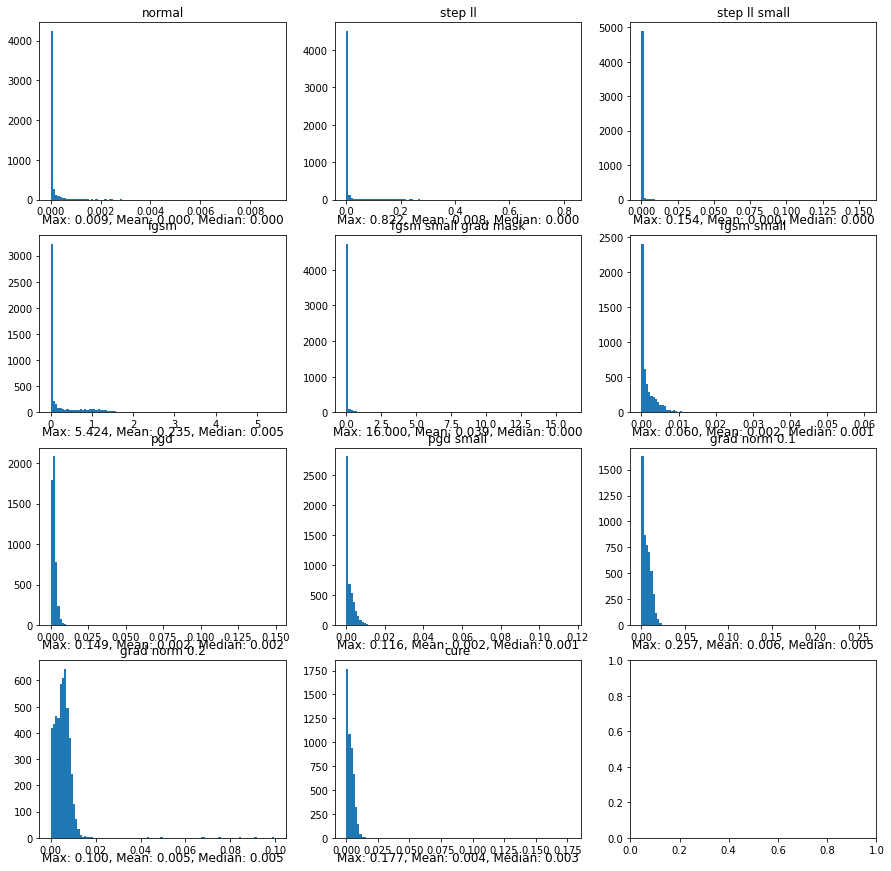

In [ ]:
compare_models_on_measure(gradient_norm, models, names, train_dataset, subset_size=5000, device=device, height=4)

### Using test dataset

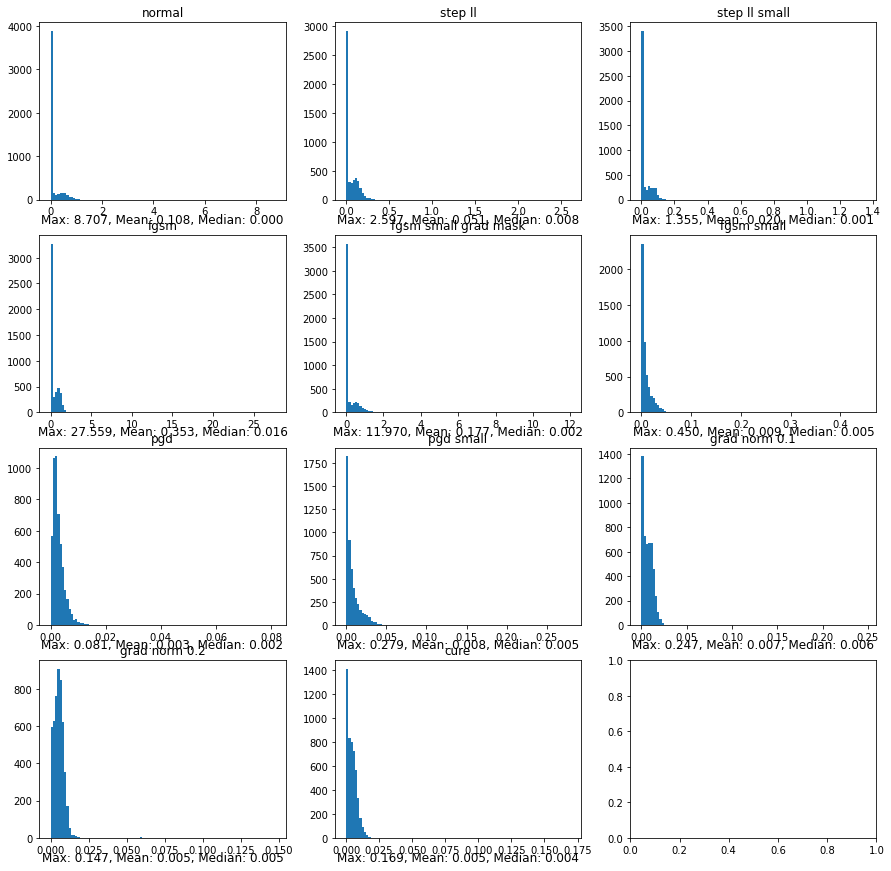

In [ ]:
compare_models_on_measure(gradient_norm, models, names, test_dataset, subset_size=5000, device=device, height=4)

## Cosine difference between FGSM and PGD

### Using train dataset

Epsilon 0.03 -- Cos Sim: 0.3241322338581085, FGSM success: 0.9593999981880188, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.19187024235725403, FGSM success: 0.9785999655723572, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.31620553135871887, FGSM success: 0.044999998062849045, PGD Success: 0.723800003528595
Epsilon 0.06 -- Cos Sim: 0.18949733674526215, FGSM success: 0.09099999815225601, PGD Success: 0.9631999731063843
Epsilon 0.03 -- Cos Sim: 0.6389132738113403, FGSM success: 0.2069999873638153, PGD Success: 0.4221999943256378
Epsilon 0.06 -- Cos Sim: 0.5036333799362183, FGSM success: 0.7897999882698059, PGD Success: 0.960599958896637
Epsilon 0.03 -- Cos Sim: 0.08157520741224289, FGSM success: 0.11339999735355377, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.02967696450650692, FGSM success: 0.020399998873472214, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.0728110671043396, FGSM success: 0.03319999948143959, PGD Success: 0.9979999661445618
Epsilon 0.06 -- Cos Sim: 0.048465143889188766, FGSM

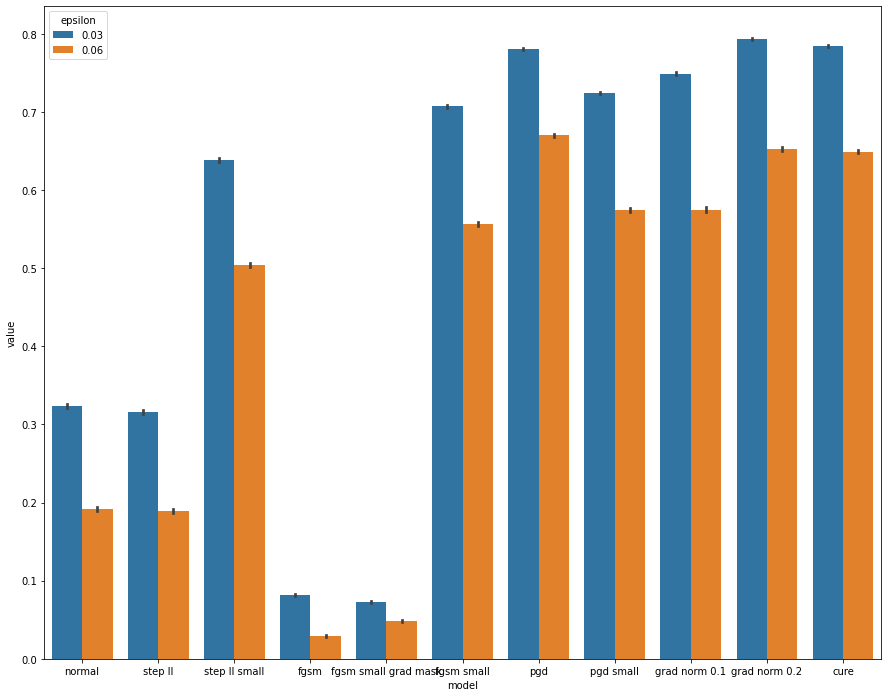

In [ ]:
cos_dif_data = [fgsm_pgd_cos_dif(cur_model, train_dataset, epsilons=[0.03, 0.06], subset_size=5000, batch_size=batch_size, device=device, return_adjusted_fgsm=False) for cur_model in models]
cos_dif_data = [pd.DataFrame(data) for data in cos_dif_data]
for name, data in zip(names, cos_dif_data):
    data['model'] = name

long_form_cos_dif_data = pd.melt(pd.concat(cos_dif_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_cos_dif_data, x='model', y='value', hue='epsilon')

### Using test dataset

Epsilon 0.03 -- Cos Sim: 0.33867454528808594, FGSM success: 0.9617999792098999, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.20685793459415436, FGSM success: 0.9771999716758728, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.3141286075115204, FGSM success: 0.5345999598503113, PGD Success: 0.8905999660491943
Epsilon 0.06 -- Cos Sim: 0.19450317323207855, FGSM success: 0.6173999905586243, PGD Success: 0.9803999662399292
Epsilon 0.03 -- Cos Sim: 0.6572256684303284, FGSM success: 0.69159996509552, PGD Success: 0.7752000093460083
Epsilon 0.06 -- Cos Sim: 0.5235006809234619, FGSM success: 0.8849999904632568, PGD Success: 0.9702000021934509
Epsilon 0.03 -- Cos Sim: 0.07898714393377304, FGSM success: 0.2078000009059906, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.03015272133052349, FGSM success: 0.08320000022649765, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.07372425496578217, FGSM success: 0.23659999668598175, PGD Success: 0.9989999532699585
Epsilon 0.06 -- Cos Sim: 0.0481916181743145, FGSM succe

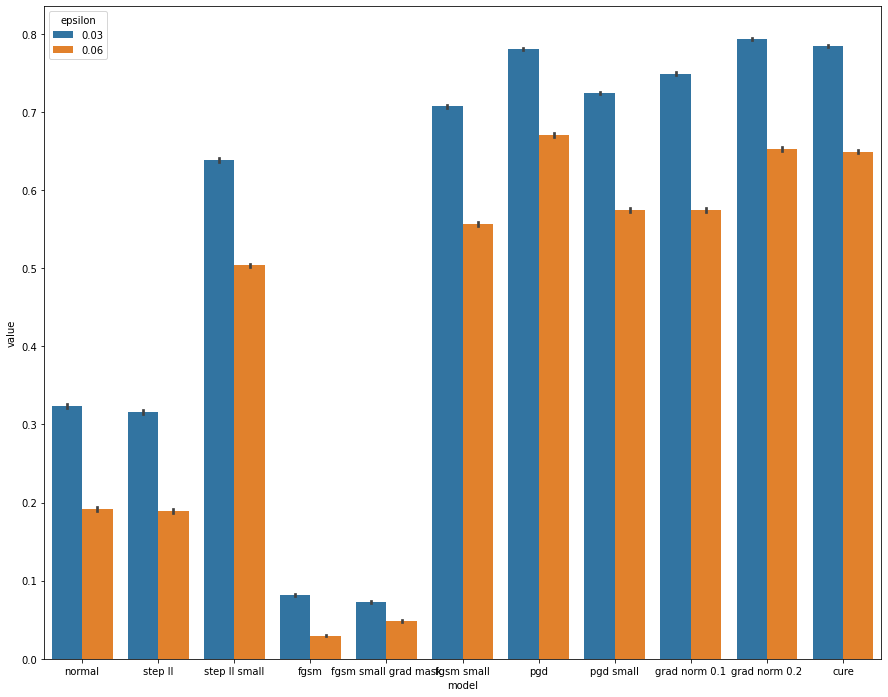

In [ ]:
cos_dif_data = [fgsm_pgd_cos_dif(cur_model, test_dataset, epsilons=[0.03, 0.06], subset_size=5000, batch_size=batch_size, device=device, return_adjusted_fgsm=False) for cur_model in models]
cos_dif_data = [pd.DataFrame(data) for data in cos_dif_data]
for name, data in zip(names, cos_dif_data):
    data['model'] = name

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_cos_dif_data, x='model', y='value', hue='epsilon')

## Linearizability of Model

#### Training data

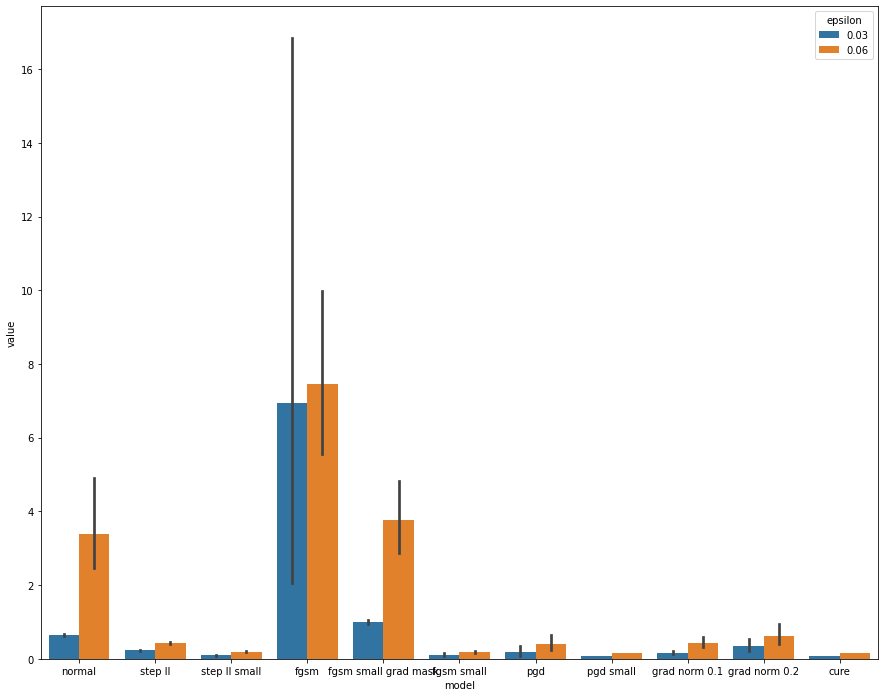

In [ ]:
linearization_data = [linearization_error(cur_model, train_dataset, epsilons=[0.03, 0.06], subset=1000, batch_size=64, n_perturbations=64*2, device=device) for cur_model in models]
linearization_data = [pd.DataFrame(data) for data in linearization_data]
for name, data in zip(names, linearization_data):
    data['model'] = name

long_form_data = pd.melt(pd.concat(linearization_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_data, x='model', y='value', hue='epsilon')

In [ ]:
long_form_data.groupby(['model', 'epsilon']).mean()

value
model                epsilon          
cure                 0.03     0.074374
                     0.06     0.156276
fgsm                 0.03     6.949190
                     0.06     7.445059
fgsm small           0.03     0.103403
                     0.06     0.171989
fgsm small grad mask 0.03     0.997553
                     0.06     3.763420
grad norm 0.1        0.03     0.169340
                     0.06     0.433508
grad norm 0.2        0.03     0.352433
                     0.06     0.626444
normal               0.03     0.643916
                     0.06     3.377492
pgd                  0.03     0.181632
                     0.06     0.390822
pgd small            0.03     0.069961
                     0.06     0.156500
step ll              0.03     0.229506
                     0.06     0.432129
step ll small        0.03     0.091723
                     0.06     0.196527

38
5
13
9
83
52
31
17
41
16
0
0
0
0
0
0
0
0
0
0
0
0


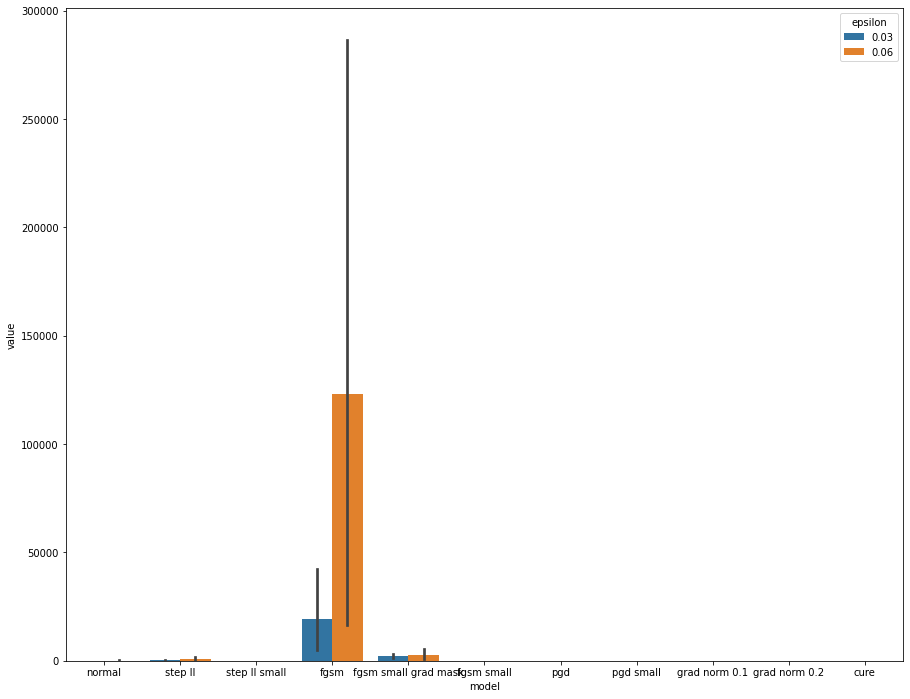

In [ ]:
linearization_data = [linearization_error(cur_model, train_dataset, epsilons=[0.03, 0.06], subset=1000, batch_size=64, n_perturbations=64*2, device=device, loss=True) for cur_model in models]
linearization_data = [pd.DataFrame(data) for data in linearization_data]
for name, data in zip(names, linearization_data):
    data['model'] = name

long_form_data = pd.melt(pd.concat(linearization_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_data, x='model', y='value', hue='epsilon')

In [ ]:
long_form_data.groupby(['model', 'epsilon']).mean()

value
model                epsilon               
cure                 0.03          0.232115
                     0.06          0.458461
fgsm                 0.03      19223.004281
                     0.06     123141.309525
fgsm small           0.03          0.485447
                     0.06          0.871696
fgsm small grad mask 0.03       2154.901791
                     0.06       2613.484719
grad norm 0.1        0.03          0.322072
                     0.06          0.625675
grad norm 0.2        0.03          0.164887
                     0.06          0.329689
normal               0.03         46.820419
                     0.06        129.355816
pgd                  0.03          0.064130
                     0.06          0.127525
pgd small            0.03          0.431111
                     0.06          0.754074
step ll              0.03        257.462711
                     0.06        782.455179
step ll small        0.03          1.735615
                     0.06          3.249561

#### Testing data

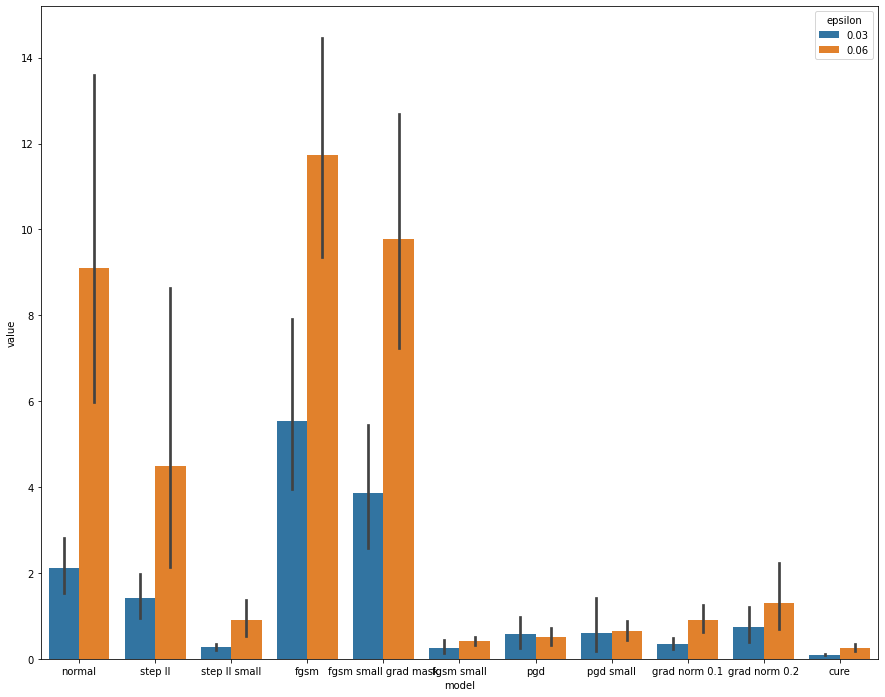

In [ ]:
linearization_data = [linearization_error(cur_model, test_dataset, epsilons=[0.03, 0.06], subset=1000, batch_size=64, n_perturbations=64*2, device=device) for cur_model in models]
linearization_data = [pd.DataFrame(data) for data in linearization_data]
for name, data in zip(names, linearization_data):
    data['model'] = name

long_form_data = pd.melt(pd.concat(linearization_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_data, x='model', y='value', hue='epsilon')

In [ ]:
long_form_data.groupby(['model', 'epsilon']).mean()

value
model                epsilon           
cure                 0.03      0.094946
                     0.06      0.241856
fgsm                 0.03      5.532991
                     0.06     11.738346
fgsm small           0.03      0.261075
                     0.06      0.412362
fgsm small grad mask 0.03      3.872869
                     0.06      9.777318
grad norm 0.1        0.03      0.354238
                     0.06      0.904164
grad norm 0.2        0.03      0.743483
                     0.06      1.298918
normal               0.03      2.120855
                     0.06      9.099345
pgd                  0.03      0.568668
                     0.06      0.496754
pgd small            0.03      0.604098
                     0.06      0.638327
step ll              0.03      1.406148
                     0.06      4.488905
step ll small        0.03      0.265204
                     0.06      0.905836

52
5
3
2
57
40
40
23
29
8
0
0
0
0
0
0
0
0
0
0
0
0


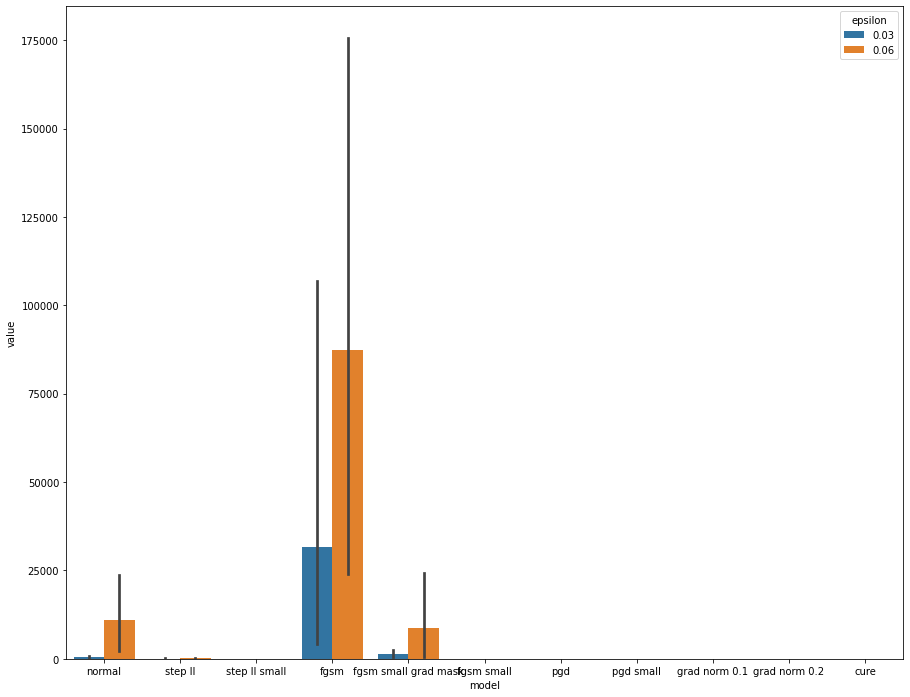

In [ ]:
linearization_data = [linearization_error(cur_model, test_dataset, epsilons=[0.03, 0.06], subset=1000, batch_size=64, n_perturbations=64*2, device=device, loss=True) for cur_model in models]
linearization_data = [pd.DataFrame(data) for data in linearization_data]
for name, data in zip(names, linearization_data):
    data['model'] = name

long_form_data = pd.melt(pd.concat(linearization_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_data, x='model', y='value', hue='epsilon')

In [ ]:
long_form_data.groupby(['model', 'epsilon']).mean()

value
model                epsilon              
cure                 0.03         0.232215
                     0.06         0.455520
fgsm                 0.03      8374.312122
                     0.06     27709.863948
fgsm small           0.03         0.468055
                     0.06         0.828040
fgsm small grad mask 0.03      1055.376675
                     0.06       446.921658
grad norm 0.1        0.03         0.334305
                     0.06         0.636291
grad norm 0.2        0.03         0.164839
                     0.06         0.335297
normal               0.03        35.423293
                     0.06       137.525557
pgd                  0.03         0.064376
                     0.06         0.123303
pgd small            0.03         0.417876
                     0.06         0.741199
step ll              0.03       112.743046
                     0.06       436.447004
step ll small        0.03         1.702600
                     0.06         3.183189

## Gradient Information

#### Training data

128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. e

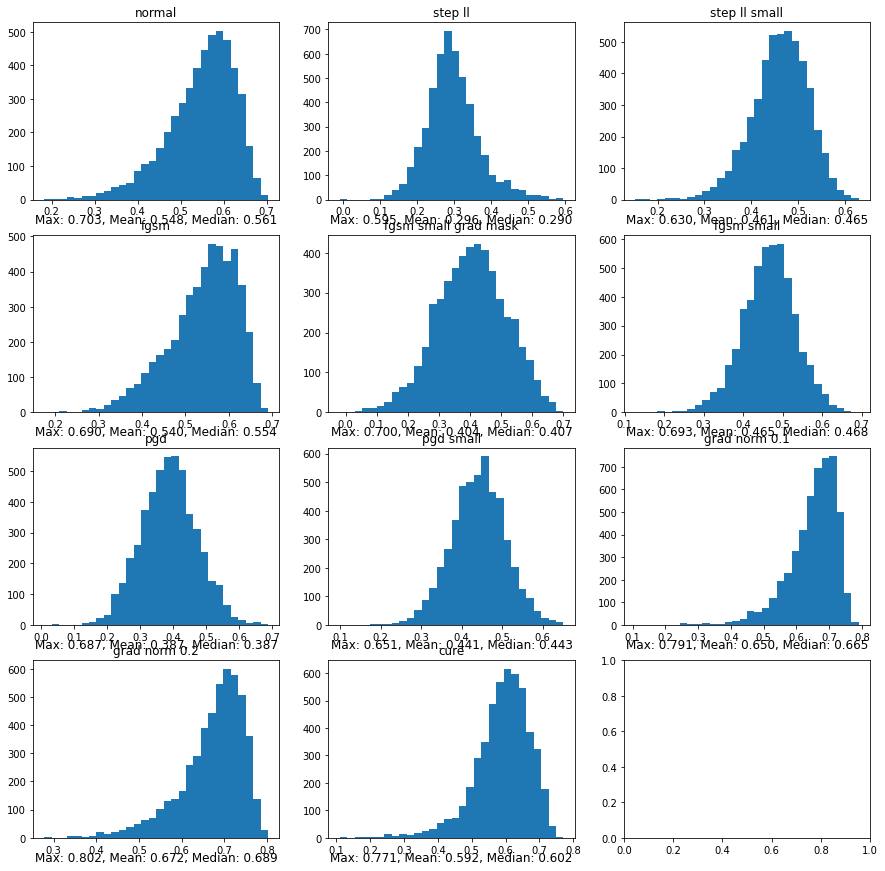

In [ ]:
compare_models_on_measure(gradient_information, models, names, train_dataset, iters=5, height=4, bins=30, device=device, subset_size=5000)

#### Testing data

127 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. examples found from 128 data points
128 adv. e

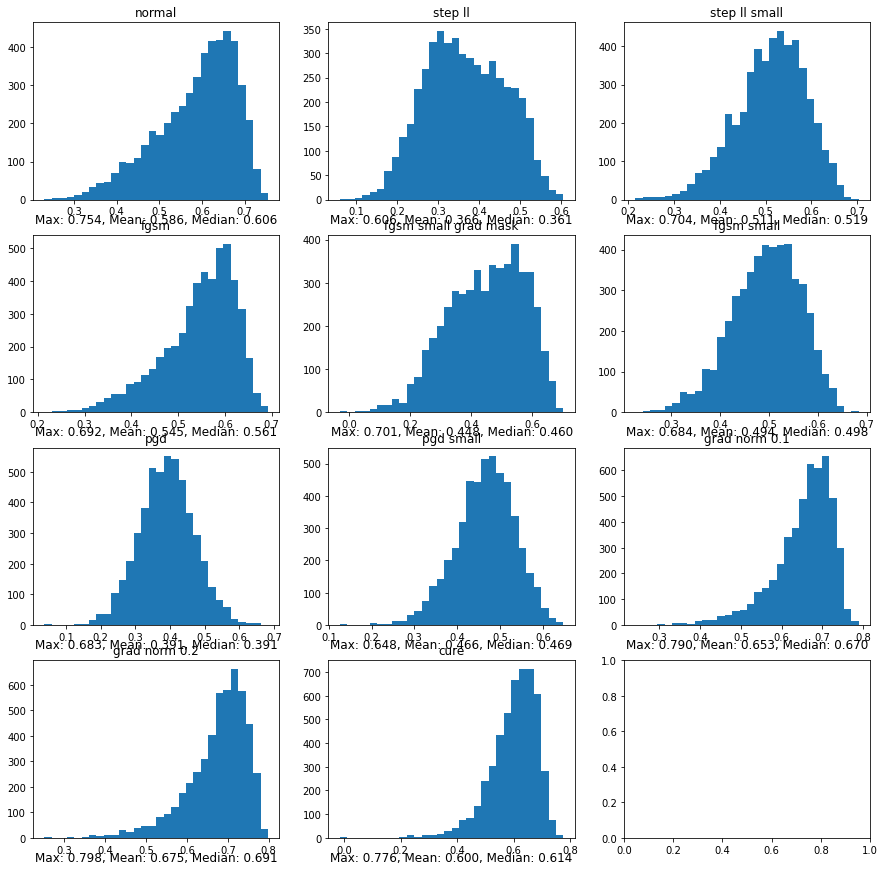

In [ ]:
compare_models_on_measure(gradient_information, models, names, test_dataset, iters=5, height=4, bins=30, device=device, subset_size=5000)

### PGD Colinearity

In [5]:
colinearity = pd.read_csv("../pgd_colinearity.csv")
colinearity = colinearity.drop(columns=[colinearity.columns[0]])

In [8]:
long_form_data = colinearity.drop(columns=['mean', 'sum']).melt(id_vars=['model'])

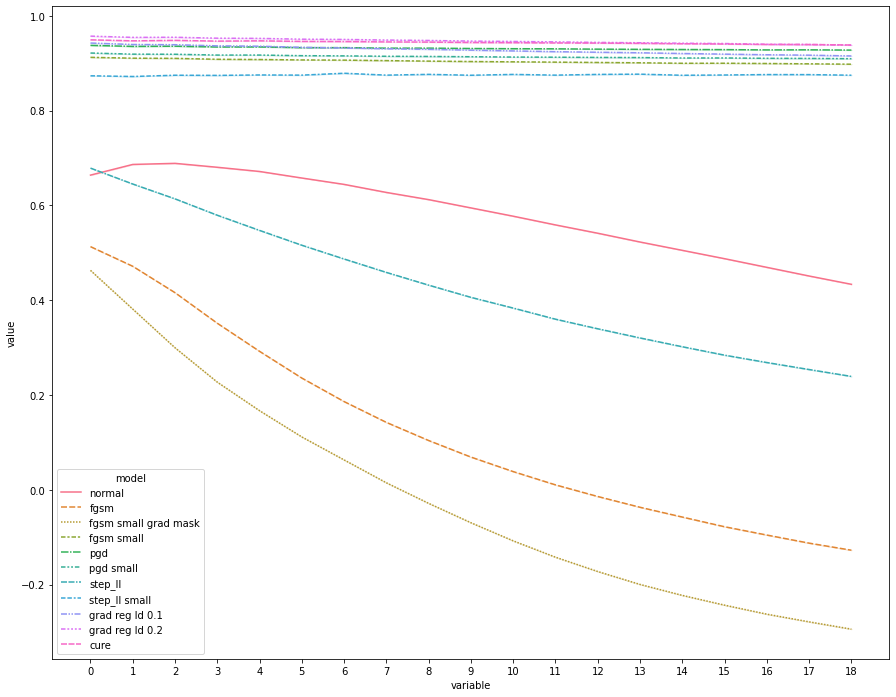

In [11]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.lineplot(ax=ax, data=long_form_data, x='variable', y='value', hue='model', style='model', ci=False)

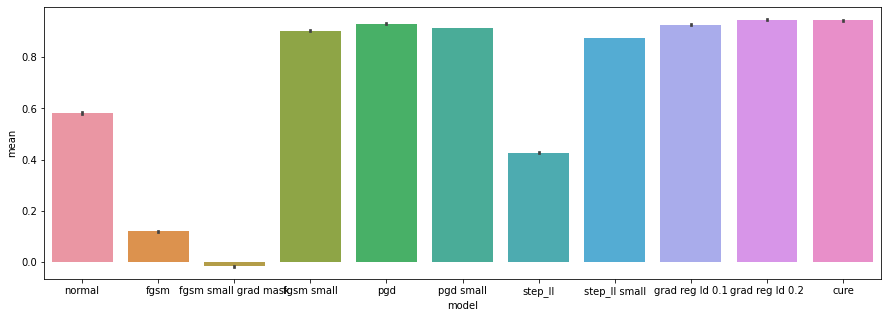

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(ax=ax, data=colinearity, x='model', y='mean')

In [13]:
less_than_zero = colinearity.drop(columns=['model', 'sum', 'mean']) < 0
cut_off_data = colinearity.drop(columns=['model', 'sum', 'mean'])
cut_off_data[less_than_zero] = np.NaN
cut_off_data['mean'] = cut_off_data.mean(axis=1, skipna=True)

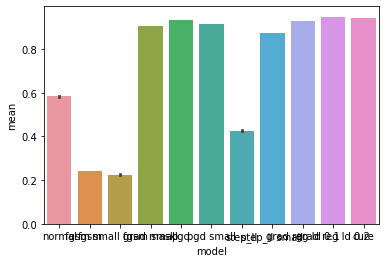

In [15]:
cut_off_data['model'] = colinearity['model']
sns.barplot(data=cut_off_data, x='model', y='mean')

In [16]:
colinearity = pd.read_csv("../pgd_colinearity_rstep.csv")
colinearity = colinearity.drop(columns=[colinearity.columns[0]])

In [17]:
long_form_data = colinearity.drop(columns=['mean', 'sum']).melt(id_vars=['model'])

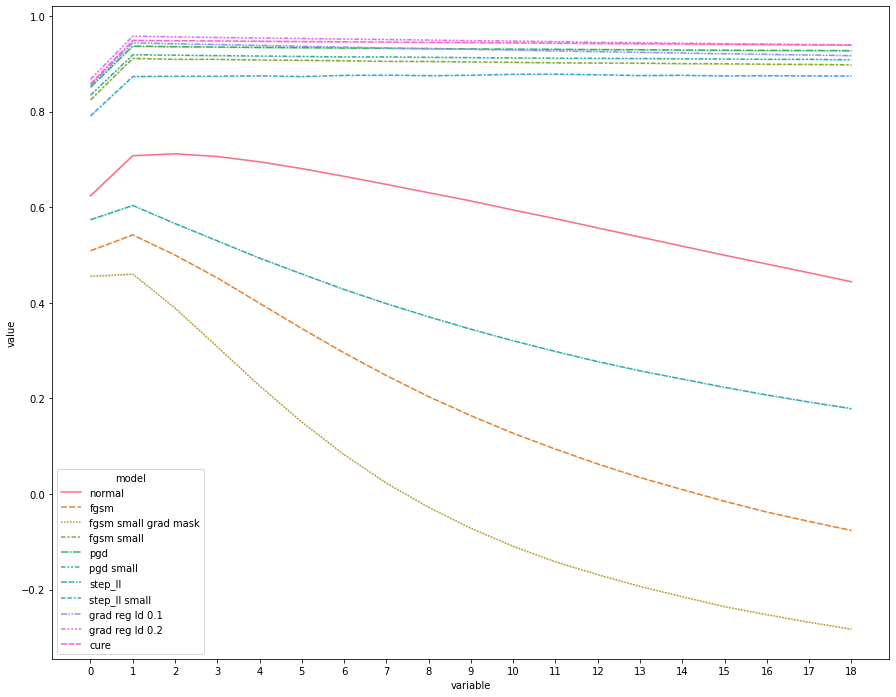

In [18]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.lineplot(ax=ax, data=long_form_data, x='variable', y='value', hue='model', style='model', ci=False)

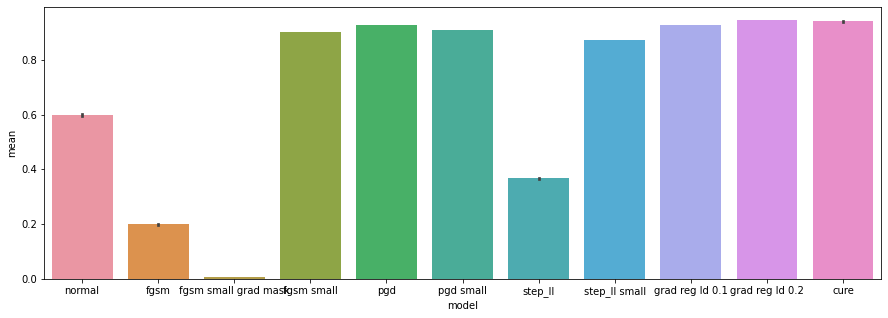

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(ax=ax, data=colinearity, x='model', y='mean')

In [20]:
less_than_zero = colinearity.drop(columns=['model', 'sum', 'mean']) < 0
cut_off_data = colinearity.drop(columns=['model', 'sum', 'mean'])
cut_off_data[less_than_zero] = np.NaN
cut_off_data['mean'] = cut_off_data.mean(axis=1, skipna=True)

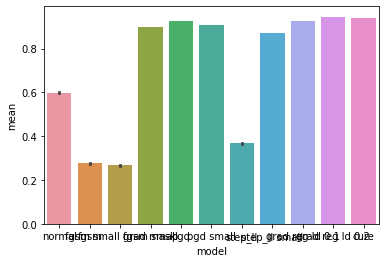

In [21]:
cut_off_data['model'] = colinearity['model']
sns.barplot(data=cut_off_data, x='model', y='mean')

### PGD Colinearity - non sequential

In [22]:
colinearity = pd.read_csv("../pgd_colinearity_non_sequential.csv")
colinearity = colinearity.drop(columns=[colinearity.columns[0]])

In [23]:
long_form_data = colinearity.drop(columns=['mean', 'sum']).melt(id_vars=['model'])

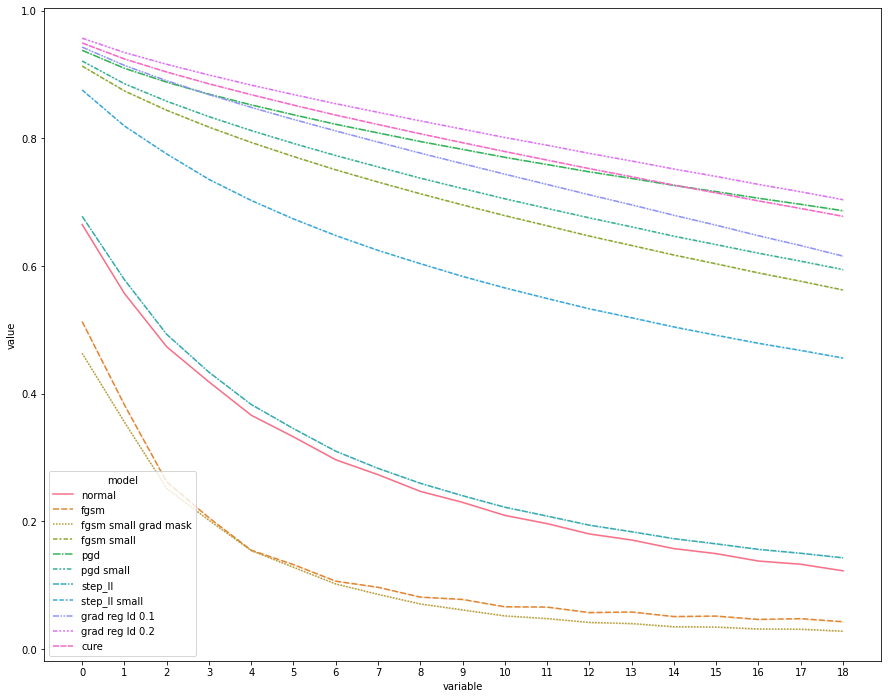

In [24]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.lineplot(ax=ax, data=long_form_data, x='variable', y='value', style='model',hue='model', ci=False)

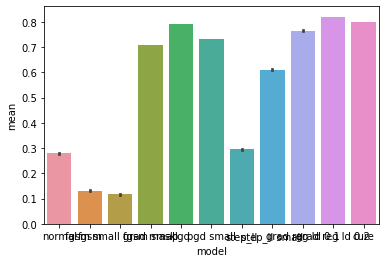

In [25]:
sns.barplot(data=colinearity, x='model', y='mean')

In [26]:
less_than_zero = colinearity.drop(columns=['model', 'sum', 'mean']) < 0
cut_off_data = colinearity.drop(columns=['model', 'sum', 'mean'])
cut_off_data[less_than_zero] = np.NaN
cut_off_data['mean'] = cut_off_data.mean(axis=1, skipna=True)

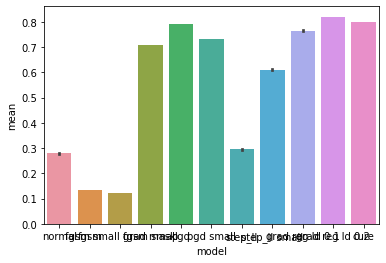

In [27]:
cut_off_data['model'] = colinearity['model']
sns.barplot(data=cut_off_data, x='model', y='mean')

In [28]:
colinearity = pd.read_csv("../pgd_colinearity_non_sequential_rstep.csv")
colinearity = colinearity.drop(columns=[colinearity.columns[0]])

In [ ]:
long_form_data = colinearity.drop(columns=['mean', 'sum']).melt(id_vars=['model'])

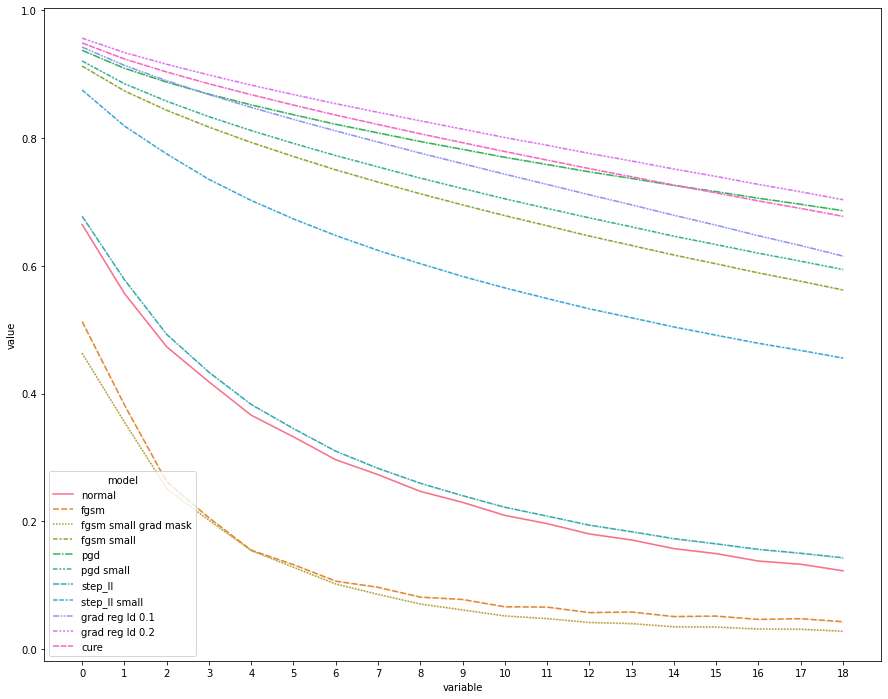

In [29]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.lineplot(ax=ax, data=long_form_data, x='variable', y='value', style='model',hue='model', ci=False)

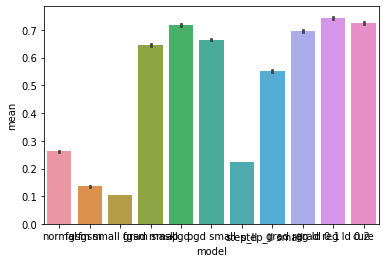

In [30]:
sns.barplot(data=colinearity, x='model', y='mean')

In [31]:
less_than_zero = colinearity.drop(columns=['model', 'sum', 'mean']) < 0
cut_off_data = colinearity.drop(columns=['model', 'sum', 'mean'])
cut_off_data[less_than_zero] = np.NaN
cut_off_data['mean'] = cut_off_data.mean(axis=1, skipna=True)

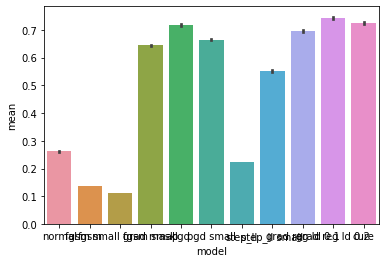

In [32]:
cut_off_data['model'] = colinearity['model']
sns.barplot(data=cut_off_data, x='model', y='mean')